In [1]:
import os

import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [3]:
f = open("..\data\measurements.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [4]:
import albumentations as alb

def augment(train_set, train_labels, iterations):
    # Define a list of image augmentation transformations to apply
    aug_transforms = [
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.RandomRotate90(),
        alb.Transpose(),
        alb.RandomBrightnessContrast()
    ]

    # Use the Compose function to apply the transformations
    aug = alb.Compose(aug_transforms)

    # Set the number of times to augment the images
    num_augmentations = iterations

    # Iterate through the number of augmentations
    for i in range(num_augmentations):
      # Iterate through your training set and apply the augmentations to each image
      augmented_train_set = []
      augmented_train_labels = []
      for image, label in zip(train_set, train_labels):
        augmented_image = aug(image=image)['image']
        augmented_train_set.append(augmented_image)
        augmented_train_labels.append(label)

      # Add the augmented images and labels to the training set
      train_set = np.concatenate((train_set, augmented_train_set))
      train_labels = np.concatenate((train_labels, augmented_train_labels))

    # Shuffle the training set and labels
    p = np.random.permutation(len(train_set))
    X = train_set[p]
    y = train_labels[p]
    return X, y


In [5]:
"""
    number: depth=0, RGB=1, depth/RGB=2, augment_data: amount of times for data to be augmented
"""
def prepare_data(number=0, y_key='Height', augment_data=0, normalized = True):

    all_images = []
    y = []

    if number == 2:
        path_RGB = '../data/RGBImagesResize/'
        key_RGB = 'RGB_Image'
        flag_RGB = cv2.IMREAD_COLOR

        path_depth = '../data/DepthImagesResize/'
        key_depth = 'Depth_Information'
        flag_depth = cv2.IMREAD_GRAYSCALE

        for image_path_RGB in os.listdir(path_RGB):
            if df.loc[df[key_RGB] == image_path_RGB][y_key].size > 0:
                img_ID = image_path_RGB.strip(".png").strip("RGB_")
                y.append(df.loc[df[key_RGB] == image_path_RGB][y_key].item())
                img_RGB = cv2.imread(path_RGB + image_path_RGB, flag_RGB)
                img_RGB = cv2.resize(img_RGB, (250, 250))
                image_path_depth = path_depth + "Depth_"+ img_ID + ".png"
                img_depth = cv2.imread(image_path_depth, flag_depth)
                img_depth = cv2.resize(img_depth, (250,250))
                if normalized:
                    img_RGB = img_RGB.astype(np.float32) / 255.0
                    img_depth = img_depth.astype(np.float32) / 255.0

                img_combined = np.dstack((img_RGB, img_depth))
                all_images.append(img_combined)
    else:
        if number == 1:
            path = '../data/RGBImagesResize/'
            key = 'RGB_Image'
            flag = cv2.IMREAD_COLOR
        else:
            path = '../data/DepthImagesResize/'
            key = 'Depth_Information'
            flag = cv2.IMREAD_GRAYSCALE

        for image_path in os.listdir(path):
            if df.loc[df[key] == image_path][y_key].size > 0:
                y.append(df.loc[df[key] == image_path][y_key].item())
                img = cv2.imread(path + image_path, flag)
                img = cv2.resize(img, (250, 250))
                if normalized:
                    img = img.astype(np.float32) / 255.0
                all_images.append(img)


    X_train, X_test, y_train, y_test = train_test_split(np.array(all_images), y, test_size=0.25, shuffle=True)

    if augment_data > 0:
        X_train, y_train = augment(X_train, y_train, augment_data)

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

    return X_train, y_train, X_test, y_test

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [6]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [7]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [8]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [9]:
def create_res_net(input_shape, regression):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(19, activation='softmax')(t)

    if regression:
        outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    if regression:
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )
    else:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

def fit_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    name = 'res_net'+timestr

    checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    os.system('mkdir {}'.format(checkpoint_dir))

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=0,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    tensorboard_callback = TensorBoard(
        log_dir=f'tensorboard_logs/{name}',
        histogram_freq=1
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        callbacks=[cp_callback, tensorboard_callback]
    )

In [12]:
model = create_res_net((250,250,4),True)
X_train, y_train, X_test, y_test = prepare_data(2, 'Diameter', 1, True)
print(X_train.shape)
fit_model(model, 100, 16, X_train, y_train, X_test, y_test)

(580, 250, 250, 4)
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 90.1663 - mean_absolute_percentage_error: 31.4015

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0001.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0001.ckpt\assets


37/37 [==============================] - 57s 1s/step - loss: 90.1663 - mean_absolute_percentage_error: 31.4015 - val_loss: 134362080.0000 - val_mean_absolute_percentage_error: 48469.0156
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 20.3901 - mean_absolute_percentage_error: 16.4037

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0002.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0002.ckpt\assets


37/37 [==============================] - 52s 1s/step - loss: 20.3901 - mean_absolute_percentage_error: 16.4037 - val_loss: 251733.2812 - val_mean_absolute_percentage_error: 2449.6719
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 19.1101 - mean_absolute_percentage_error: 15.3158

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0003.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0003.ckpt\assets


37/37 [==============================] - 52s 1s/step - loss: 19.1101 - mean_absolute_percentage_error: 15.3158 - val_loss: 1270.4800 - val_mean_absolute_percentage_error: 123.7962
Epoch 4/100
37/37 [==============================] - ETA: 0s - loss: 19.4678 - mean_absolute_percentage_error: 15.4022

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0004.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0004.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 19.4678 - mean_absolute_percentage_error: 15.4022 - val_loss: 519.2493 - val_mean_absolute_percentage_error: 82.1488
Epoch 5/100
37/37 [==============================] - 42s 1s/step - loss: 14.1905 - mean_absolute_percentage_error: 13.8990 - val_loss: 618.4908 - val_mean_absolute_percentage_error: 112.5506
Epoch 6/100
37/37 [==============================] - ETA: 0s - loss: 20.7252 - mean_absolute_percentage_error: 16.1876

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0006.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0006.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 20.7252 - mean_absolute_percentage_error: 16.1876 - val_loss: 205.3041 - val_mean_absolute_percentage_error: 56.3286
Epoch 7/100
37/37 [==============================] - ETA: 0s - loss: 11.8855 - mean_absolute_percentage_error: 12.2689

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0007.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0007.ckpt\assets


37/37 [==============================] - 50s 1s/step - loss: 11.8855 - mean_absolute_percentage_error: 12.2689 - val_loss: 116.7254 - val_mean_absolute_percentage_error: 33.5143
Epoch 8/100
37/37 [==============================] - ETA: 0s - loss: 14.7661 - mean_absolute_percentage_error: 14.6407

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0008.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0008.ckpt\assets


37/37 [==============================] - 51s 1s/step - loss: 14.7661 - mean_absolute_percentage_error: 14.6407 - val_loss: 26.5912 - val_mean_absolute_percentage_error: 17.5338
Epoch 9/100
37/37 [==============================] - 41s 1s/step - loss: 14.3082 - mean_absolute_percentage_error: 13.7171 - val_loss: 30.6453 - val_mean_absolute_percentage_error: 24.3722
Epoch 10/100
37/37 [==============================] - ETA: 0s - loss: 12.7238 - mean_absolute_percentage_error: 12.9869

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0010.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0010.ckpt\assets


37/37 [==============================] - 51s 1s/step - loss: 12.7238 - mean_absolute_percentage_error: 12.9869 - val_loss: 13.8563 - val_mean_absolute_percentage_error: 11.7354
Epoch 11/100
37/37 [==============================] - ETA: 0s - loss: 11.5371 - mean_absolute_percentage_error: 12.2868

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0011.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0011.ckpt\assets


37/37 [==============================] - 52s 1s/step - loss: 11.5371 - mean_absolute_percentage_error: 12.2868 - val_loss: 13.3344 - val_mean_absolute_percentage_error: 10.0632
Epoch 12/100
37/37 [==============================] - 42s 1s/step - loss: 8.9000 - mean_absolute_percentage_error: 11.0146 - val_loss: 16.2716 - val_mean_absolute_percentage_error: 14.0481
Epoch 13/100
37/37 [==============================] - 42s 1s/step - loss: 13.7177 - mean_absolute_percentage_error: 13.5588 - val_loss: 39.1966 - val_mean_absolute_percentage_error: 17.8092
Epoch 14/100
37/37 [==============================] - 42s 1s/step - loss: 12.7653 - mean_absolute_percentage_error: 12.5630 - val_loss: 54.0573 - val_mean_absolute_percentage_error: 18.5696
Epoch 15/100
37/37 [==============================] - 42s 1s/step - loss: 11.5504 - mean_absolute_percentage_error: 11.7978 - val_loss: 42.3852 - val_mean_absolute_percentage_error: 25.2938
Epoch 16/100
37/37 [==============================] - 42s 1s/ste

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0024.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0024.ckpt\assets


37/37 [==============================] - 52s 1s/step - loss: 9.7550 - mean_absolute_percentage_error: 10.7929 - val_loss: 12.0035 - val_mean_absolute_percentage_error: 11.6943
Epoch 25/100
37/37 [==============================] - 44s 1s/step - loss: 10.5473 - mean_absolute_percentage_error: 11.4981 - val_loss: 14.8976 - val_mean_absolute_percentage_error: 13.1720
Epoch 26/100
37/37 [==============================] - ETA: 0s - loss: 9.5817 - mean_absolute_percentage_error: 11.3112

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0026.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0026.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 9.5817 - mean_absolute_percentage_error: 11.3112 - val_loss: 9.1557 - val_mean_absolute_percentage_error: 10.2192
Epoch 27/100
37/37 [==============================] - ETA: 0s - loss: 8.9627 - mean_absolute_percentage_error: 10.6316

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0027.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0027.ckpt\assets


37/37 [==============================] - 56s 2s/step - loss: 8.9627 - mean_absolute_percentage_error: 10.6316 - val_loss: 8.5319 - val_mean_absolute_percentage_error: 10.6038
Epoch 28/100
37/37 [==============================] - 45s 1s/step - loss: 8.5968 - mean_absolute_percentage_error: 10.6348 - val_loss: 41.9305 - val_mean_absolute_percentage_error: 15.7170
Epoch 29/100
37/37 [==============================] - 45s 1s/step - loss: 8.5651 - mean_absolute_percentage_error: 10.7906 - val_loss: 56.0248 - val_mean_absolute_percentage_error: 17.2336
Epoch 30/100
37/37 [==============================] - 45s 1s/step - loss: 10.0085 - mean_absolute_percentage_error: 11.5351 - val_loss: 58.3948 - val_mean_absolute_percentage_error: 19.2757
Epoch 31/100
37/37 [==============================] - 45s 1s/step - loss: 8.9424 - mean_absolute_percentage_error: 11.2890 - val_loss: 9.4035 - val_mean_absolute_percentage_error: 10.8281
Epoch 32/100
37/37 [==============================] - 45s 1s/step - l

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0037.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0037.ckpt\assets


37/37 [==============================] - 55s 1s/step - loss: 8.2503 - mean_absolute_percentage_error: 10.1984 - val_loss: 8.2867 - val_mean_absolute_percentage_error: 10.3932
Epoch 38/100
37/37 [==============================] - 44s 1s/step - loss: 12.0664 - mean_absolute_percentage_error: 11.7634 - val_loss: 15.3987 - val_mean_absolute_percentage_error: 14.7756
Epoch 39/100
37/37 [==============================] - 43s 1s/step - loss: 14.9221 - mean_absolute_percentage_error: 13.5093 - val_loss: 12.7324 - val_mean_absolute_percentage_error: 13.8070
Epoch 40/100
37/37 [==============================] - 42s 1s/step - loss: 9.3480 - mean_absolute_percentage_error: 11.1549 - val_loss: 15.8585 - val_mean_absolute_percentage_error: 14.7236
Epoch 41/100
37/37 [==============================] - 42s 1s/step - loss: 7.5346 - mean_absolute_percentage_error: 9.7046 - val_loss: 19.1065 - val_mean_absolute_percentage_error: 17.6072
Epoch 42/100
37/37 [==============================] - 43s 1s/step - 

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0067.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0067.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 7.7189 - mean_absolute_percentage_error: 10.1485 - val_loss: 7.2576 - val_mean_absolute_percentage_error: 10.3728
Epoch 68/100
37/37 [==============================] - 42s 1s/step - loss: 6.3657 - mean_absolute_percentage_error: 9.3986 - val_loss: 8.3495 - val_mean_absolute_percentage_error: 10.9839
Epoch 69/100
37/37 [==============================] - 42s 1s/step - loss: 6.8215 - mean_absolute_percentage_error: 9.6724 - val_loss: 8.3866 - val_mean_absolute_percentage_error: 10.9840
Epoch 70/100
37/37 [==============================] - ETA: 0s - loss: 6.8077 - mean_absolute_percentage_error: 9.8314

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0070.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0070.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 6.8077 - mean_absolute_percentage_error: 9.8314 - val_loss: 6.9816 - val_mean_absolute_percentage_error: 10.3585
Epoch 71/100
37/37 [==============================] - 42s 1s/step - loss: 6.2606 - mean_absolute_percentage_error: 9.3856 - val_loss: 7.6323 - val_mean_absolute_percentage_error: 10.8704
Epoch 72/100
37/37 [==============================] - 42s 1s/step - loss: 6.2885 - mean_absolute_percentage_error: 9.2790 - val_loss: 7.6547 - val_mean_absolute_percentage_error: 9.4691
Epoch 73/100
37/37 [==============================] - 43s 1s/step - loss: 7.6629 - mean_absolute_percentage_error: 10.4903 - val_loss: 7.2407 - val_mean_absolute_percentage_error: 10.3199
Epoch 74/100
37/37 [==============================] - 43s 1s/step - loss: 6.9627 - mean_absolute_percentage_error: 9.7269 - val_loss: 9.8274 - val_mean_absolute_percentage_error: 12.2609
Epoch 75/100
37/37 [==============================] - 43s 1s/step - loss: 6.23

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0077.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0077.ckpt\assets


37/37 [==============================] - 52s 1s/step - loss: 6.0393 - mean_absolute_percentage_error: 9.2761 - val_loss: 6.9757 - val_mean_absolute_percentage_error: 10.2965
Epoch 78/100
37/37 [==============================] - 43s 1s/step - loss: 6.2053 - mean_absolute_percentage_error: 9.2701 - val_loss: 7.4303 - val_mean_absolute_percentage_error: 10.9269
Epoch 79/100
37/37 [==============================] - ETA: 0s - loss: 5.8372 - mean_absolute_percentage_error: 9.3231

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0079.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0079.ckpt\assets


37/37 [==============================] - 53s 1s/step - loss: 5.8372 - mean_absolute_percentage_error: 9.3231 - val_loss: 6.6380 - val_mean_absolute_percentage_error: 9.3240
Epoch 80/100
37/37 [==============================] - 41s 1s/step - loss: 5.6076 - mean_absolute_percentage_error: 8.8819 - val_loss: 7.3428 - val_mean_absolute_percentage_error: 10.3660
Epoch 81/100
37/37 [==============================] - 41s 1s/step - loss: 5.3148 - mean_absolute_percentage_error: 8.4322 - val_loss: 7.7944 - val_mean_absolute_percentage_error: 9.8721
Epoch 82/100
37/37 [==============================] - 42s 1s/step - loss: 4.9663 - mean_absolute_percentage_error: 8.3319 - val_loss: 12.9640 - val_mean_absolute_percentage_error: 14.9883
Epoch 83/100
37/37 [==============================] - 43s 1s/step - loss: 8.7890 - mean_absolute_percentage_error: 11.3917 - val_loss: 7.3710 - val_mean_absolute_percentage_error: 10.1166
Epoch 84/100
37/37 [==============================] - 42s 1s/step - loss: 5.86

INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0097.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221222-193327\cp-0097.ckpt\assets


37/37 [==============================] - 51s 1s/step - loss: 4.4099 - mean_absolute_percentage_error: 7.9327 - val_loss: 6.2315 - val_mean_absolute_percentage_error: 9.0373
Epoch 98/100
37/37 [==============================] - 42s 1s/step - loss: 5.3950 - mean_absolute_percentage_error: 8.9362 - val_loss: 7.6443 - val_mean_absolute_percentage_error: 9.0612
Epoch 99/100
37/37 [==============================] - 42s 1s/step - loss: 5.1371 - mean_absolute_percentage_error: 8.3315 - val_loss: 8.4073 - val_mean_absolute_percentage_error: 10.0848
Epoch 100/100
37/37 [==============================] - 42s 1s/step - loss: 3.8761 - mean_absolute_percentage_error: 7.5306 - val_loss: 6.6061 - val_mean_absolute_percentage_error: 9.3666


## Plots predicted vs actual

In [14]:
def plot_true_vs_predicted(model, X, y, title):
    predicted = model.predict(X)
    actual = y
    plt.plot(actual, 'bo')
    plt.plot(predicted, 'r^')

    # Draw lines between the data points
    for x1, y1, x2, y2 in zip(range(len(actual)), actual, range(len(predicted)), predicted):
        plt.plot([x1, x2], [y1, y2], 'k-')

    plt.title(title)
    plt.legend(['True data', 'Predicted data'])
    plt.show()


Diameter

4/4 [==============================] - 2s 608ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


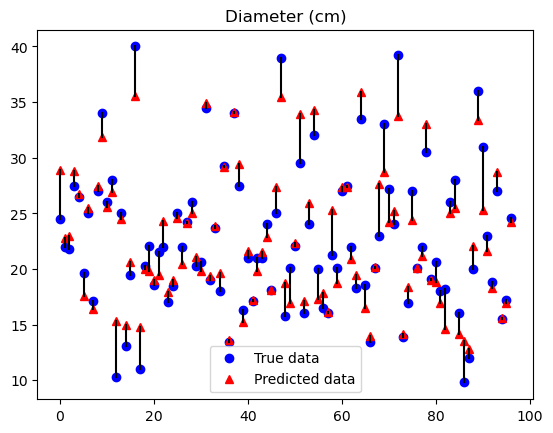

In [77]:
X_train, y_train, X_test, y_test = prepare_data(1,'Diameter',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_diameter/cp-0052.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Diameter (cm)')

Height

4/4 [==============================] - 2s 591ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


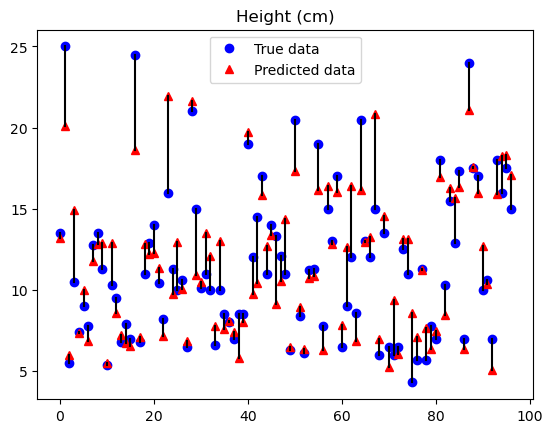

In [78]:
X_train, y_train, X_test, y_test = prepare_data(0,'Height',0, False)
model = tf.keras.models.load_model('./checkpoints/depth_height/cp-0064.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Height (cm)')

Fresh Weight

4/4 [==============================] - 2s 552ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


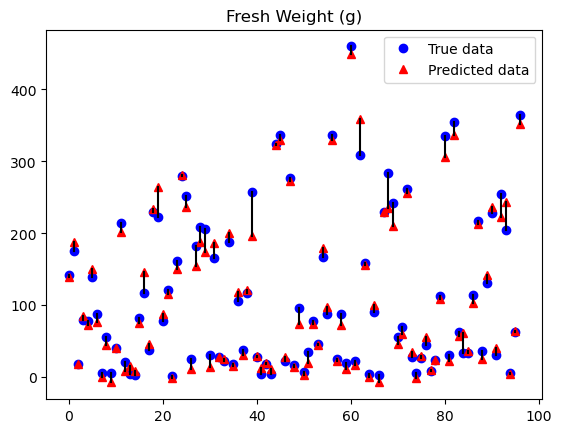

In [79]:
X_train, y_train, X_test, y_test = prepare_data(2,'FreshWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb-d_freshweight/cp-0100.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Fresh Weight (g)')

Dry Weight

4/4 [==============================] - 2s 565ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


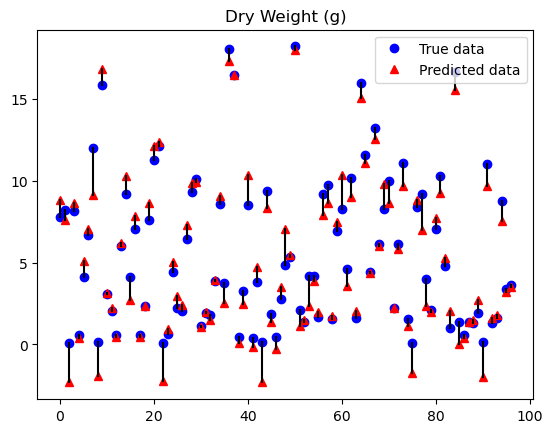

In [80]:
X_train, y_train, X_test, y_test = prepare_data(1,'DryWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb_dryweight/cp-0077.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Dry Weight (g)')

Leaf Area

In [ ]:
X_train, y_train, X_test, y_test = prepare_data(1,'LeafArea',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_leafarea/cp-0060.ckpt')

plot_true_vs_predicted(model, X_test, y_test, 'Leaf Area (cm^2)')